In [1]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [14]:
# setup
# experiments with MNIST dataset

x_dim = 400
k = 20
tolerance = 1e-7; max_iter = 4000; out_toggle = 0
trials = 20
n1 = 100
opt = Flux.Optimise.ADAM(.1);
m_list = 15:5:150

A = sample_fourier(n1, x_dim); A = A' #sub-sampled DCT matrix used in convex combination
B = randn(x_dim, n1)/sqrt(x_dim) #random matrix that is used in convex combination
W1 = randn(n1,k)/sqrt(n1)

z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

β_list, α_list = get_β_α(F, A, B, 21);

In [ ]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(k, n1, relu, bias = false; init =(out,in) -> W1),
            Dense(n1, x_dim, identity, bias = false; init =(out,in) -> β*A + (1-β) * B)
        )    #setup the generative network 

        for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix
    
            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
    println("")
end

In [ ]:
save("saved_data/Phase_plot_random.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)

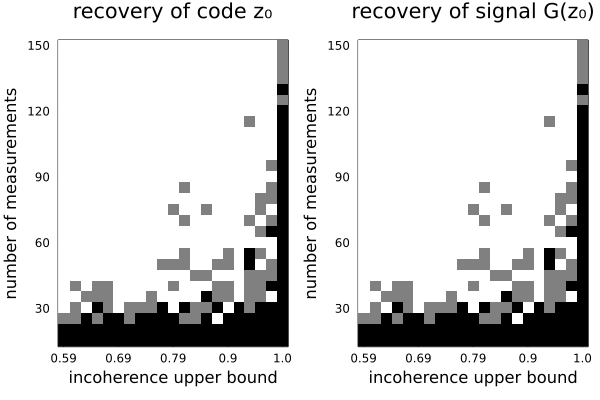

In [13]:
M = zeros(size(phase_matrix_recovery[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

p1 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of code z₀", framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

# m_pred = 150*α_list.^2
# ff(x) = -27/135 * x +(1 + 27*150/135)
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

# m_pred = 150*α_list.^3
# plot!(1:length(α_list), ff.(m_pred), label =:false, linewidth = 2 )

p2 = plot(colorview(Gray, reverse(M/trials, dims = 1)), bg =:black, title = "recovery of signal G(z₀)",framestyle = :box)
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

plot(p1, p2, layout = 2, xlabel = "incoherence upper bound", ylabel = "number of measurements")
# savefig("figures/Phase_plot_random_percentage.pdf")

In [ ]:


M = sum(phase_matrix_recovery,dims =1)[1,:,:]/20; M[M .>1] .= 1
p1 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of code z₀")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

M = sum(phase_matrix_recon,dims =1)[1,:,:]/20; M[M .>1] .= 1
p2 = plot(colorview(Gray, reverse(M,dims=1)), framestyle = :box, bg =:black, title = "recovery of signal G(z₀)")
xticks = 1:5:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:5:length(α_list)])
yticks = 1:6:length(m_list)
yticks!(yticks, ["$(m_list[length(m_list) + 1 - i])" for i in 1:6:length(m_list)])

plot(p1, p2, layout = 2,  bg =:white)
savefig("figures/Phase_plot_random_error.pdf")



In [7]:
Threads.@threads for N in 1:5:2000
    println("The number of this iteration is $N")
end

The number of this iteration is 1
The number of this iteration is 6
The number of this iteration is 11
The number of this iteration is 16
The number of this iteration is 21
The number of this iteration is 26
The number of this iteration is 751
The number of this iteration is 756
The number of this iteration is 251
The number of this iteration is 31
The number of this iteration is 36
The number of this iteration is 41
The number of this iteration is 46
The number of this iteration is 1501
The number of this iteration is 1751
The number of this iteration is 761
The number of this iteration is 1251
The number of this iteration is 1506
The number of this iteration is 256
The number of this iteration is 1511
The number of this iteration is 766
The number of this iteration is 501
The number of this iteration is 1516
The number of this iteration is 506
The number of this iteration is 1521
The number of this iteration is 1756
The number of this iteration is 1526
The number of this iteration is

The number of this iteration is 971
The number of this iteration is 446
The number of this iteration is 631
The number of this iteration is 1951
The number of this iteration is 1491
The number of this iteration is 1496
The number of this iteration is 1091
The number of this iteration is 636
The number of this iteration is 976
The number of this iteration is 451
The number of this iteration is 641
The number of this iteration is 1661
The number of this iteration is 1096
The number of this iteration is 1956
The number of this iteration is 456
The number of this iteration is 1101
The number of this iteration is 461
The number of this iteration is 1961
The number of this iteration is 466
The number of this iteration is 1966
The number of this iteration is 981
The number of this iteration is 1106
The number of this iteration is 1666
The number of this iteration is 1671
The number of this iteration is 1111
The number of this iteration is 646
The number of this iteration is 1676
The number of